# CSCI 3202, Spring 2018: Practicum

---

<a id='top'></a>

This practicum is due on Moodle by **11:59 PM on Thursday 3 May 2018**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

**The rules:**

1. All work, code and analysis must be **your own**.
1. You may use your course notes, posted lecture slides, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python.
1. You may **not** post to message boards or other online resources asking for help.
1. **You may not collaborate with classmates or anyone else.**
1. This is meant to be like a coding portion of your final exam. So, I will be much less helpful than I typically am with homework. For example, I will not check answers, help debug your code, and so on.
1. If you have a question, post it first as a **private** Piazza message. If I decide that it is appropriate for the entire class, then I will make it a public post (and anonymous).
1. If something is left open-ended, it is probably because I intend for you to code it up however you want, and only care about the plots/analysis I see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:**

---

Shortcuts:  [Top](#top) || [1. Search](#p1) | [2. Bayes nets](#p2) | [3. Markov chains](#p3) | [4. Reinforcement learning](#p4) || [Bottom](#bottom)

In [323]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

<a/ id='p1'></a>

---
## [25 pts] Problem 1:  Route-finding

Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$ with the **lowest total path cost**. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 

Of course, you can probably do this problem without a search algorithm. But (1) that will provide a useful "sanity check" for your answer, and (2) an AI agent cannot necessarily figure that out... without your help!

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you.

Print to the screen the output for `adjacent_states((1,15))`.

In [7]:
import math

# generate obstacles set
def build_graph():
    res = set()
    for i in range(21, 26):
        for j in range(11, 17):
            res.add((i, j))

    for i in range(5, 24):
        res.add((i, 1))

    for i in range(10, 14):
        for j in range(9, 13):
            res.add((i, j))
    for i in range(11, 15):
        for j in range(11, 15):
            res.add((i, j))

    for i in range(1, 5):
        for j in range(1+i, 16-i):
            res.add((i, j))

    return res

obstacles = build_graph()
dirs = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]

def adjacent_states(state):
    res = []
    for d in dirs:
        x = state[0] + d[0]
        y = state[1] + d[1]
        if 1 <= x <= 25 and 1 <= y <= 16 and (x, y) not in obstacles:
            res.append(((x, y), math.sqrt(abs(d[0])+abs(d[1]))))
    return res

print("The adjcent states of (1, 15) is: ")            
print(adjacent_states((1,15)))

The adjcent states of (1, 15) is: 
[((1, 16), 1.0), ((2, 16), 1.4142135623730951), ((2, 15), 1.0), ((2, 14), 1.4142135623730951)]


#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [9]:
def heuristic_cols(state, goal):
    # number of columns between the argument state and the goal
    return abs(state[0] - goal[0])


def heuristic_rows(state, goal):
    # number of rows between the argument state and the goal
    return abs(state[1] - goal[1])


def heuristic_eucl(state, goal):
    return math.sqrt((state[0] - goal[0]) ** 2 + (state[1] - goal[1])**2)

# Euclidean distance always greater than columns distance or rows distance
# because sqrt(x^2 + y^2) >= x and sqrt(x^2 + y^2) >= y
def heuristic_max(state, goal):
    return heuristic_eucl(state, goal)

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not. A counterexample is a great way to prove that something is not true.

#### Anwser:
No, Manhattan distance is not an admissible heuristic function for this problem. For example, if we start from (1, 15)
and goal is (2, 16), the Manhattan distance 2 is higher than the lowest possible cost $\sqrt{2}$.

#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A, similarly to the 8-tile problem from Homework 3.

In [16]:
import heapq


def path(previous, s): 
    '''generate the path
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

class Frontier_PQ(object):
    ''' priority queue class
    '''
    def __init__(self, start, cost):
        super().__init__()
        self.q = []
        heapq.heappush(self.q, (cost, start))
        self.states = {
            start: cost
        }

    def add(self, state, cost):
        heapq.heappush(self.q, (cost, state))

    def pop(self):
        return heapq.heappop(self.q)

    def replace(self, state, cost):
        self.states[state] = cost

def astar_search(start, goal, heuristic, return_cost):
    '''A* search algorithm
    '''
    open_set = Frontier_PQ(start, 0)
    close_set = set()
    g = {
        start: 0
    }
    min_cost = 0
    previous = {
        start: None
    }
    while open_set:
        cost, cur_state = open_set.pop()
        close_set.add(cur_state)
        if cur_state == goal:
            min_cost = cost
            break
        for next_state, next_cost in adjacent_states(cur_state):
            next_g = g[cur_state] + next_cost
            if next_state not in g or next_g < g[next_state]:
                g[next_state] = next_g
                previous[next_state] = cur_state
                next_f = next_g + heuristic(next_state, goal)
                open_set.replace(next_state, next_f)
                open_set.add(next_state, next_f)

    res = path(previous, goal)

    if return_cost:
        return res, min_cost
    else:
        return res
    
result_path, cost = astar_search((1, 15), (25, 9), heuristic_max, True)

print("The shortest path from the initial state at (1,15) to the goal state at (25,9): ")
print("->".join([str(coor) for coor in result_path]))
print("The final cost is {:.2f}".format(cost))

The shortest path from the initial state at (1,15) to the goal state at (25,9): 
(1, 15)->(2, 15)->(3, 15)->(4, 15)->(5, 15)->(6, 15)->(7, 15)->(8, 15)->(9, 15)->(10, 15)->(11, 15)->(12, 15)->(13, 15)->(14, 15)->(15, 14)->(16, 13)->(17, 13)->(18, 12)->(19, 12)->(20, 11)->(21, 10)->(22, 10)->(23, 10)->(24, 9)->(25, 9)
The final cost is 26.49


#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

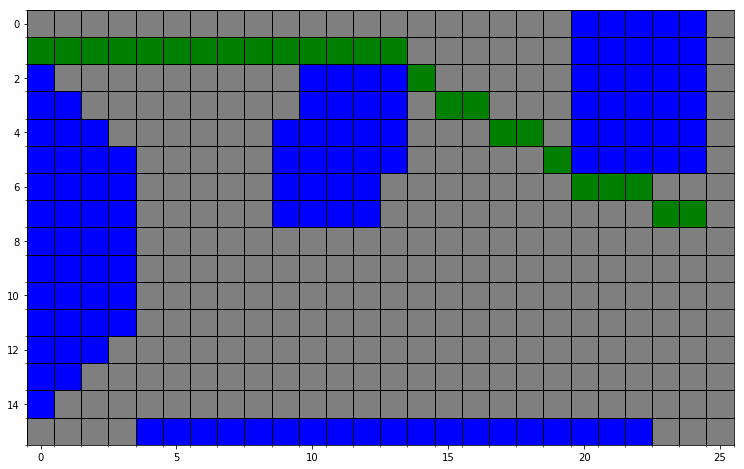

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def generate_map():
    graph = np.zeros((16, 26), dtype=int)
    for x, y in obstacles:
        graph[16-y, x-1] = 1
    return graph
    
def plot_path(graph, path):
    for x, y in path:
        graph[16-y, x-1] = 2
    plt.figure(figsize=(13,8))
    plt.imshow(graph, cmap=colors.ListedColormap(['tab:gray','b' , 'g']))
    ax = plt.gca()
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 26, 1), minor=True);
    ax.set_yticks(np.arange(-.5, 16, 1), minor=True);

    ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
    plt.show()
    
plot_path(generate_map(), result_path)

[Back to top](#top)

<a/ id='p2'></a>

<br>

---
## [25 pts] Problem 2:  Bayesian networks

#### Part A
Suppose we are about to go on a run and are trying to decide how far to run. Consider the Bayesian network depicted below for this decision. The length of our run ($R$, miles) is continuous and depends on the temperature ($T$, degrees Fahrenheit), which is also a continuous variable, and whether or not it is raining ($P$), which is a discrete Boolean variable.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/running_bayesnet.png" style="width: 450px;"/>

1. Read in the data set [`data_running.csv`](https://piazza.com/class_profile/get_resource/jc4v74a5uu5wa/jfv207i7dlqd8) from the Resources tab on Piazza (and linked here).
1. How many data points are there?
1. Make a histogram of the distribution of temperature, with appropriate axis labels.

In [38]:
import pandas as pd
df = pd.read_csv("https://piazza.com/class_profile/get_resource/jc4v74a5uu5wa/jfv207i7dlqd8", index_col=0)

There are 200 data points


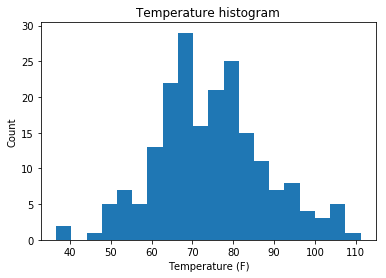

In [51]:
%matplotlib inline

print("There are {:d} data points".format(len(df.index)))
plt.hist(df["temperature"], 20)
plt.xlabel("Temperature (F)")
plt.ylabel("Count")
plt.title("Temperature histogram")
plt.show()

#### Part B

Decide on appropriate prior distributions for $P$ and $T$.  Note that $P$ is discrete (Boolean), while $T$ is continuous.  There is not necessarily only one correct response; your answer should be fully justified by calculations shown below.

0.24


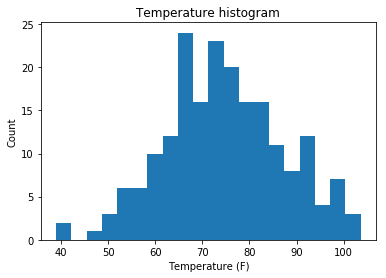

In [59]:
# the rainning probability
p_rain = len(df.loc[df["rain"]=="Yes", "rain"])/200
print(p_rain)

# prior distributions for Temperature
mu = np.mean(df["temperature"])
sigma = np.std(df["temperature"])
s = np.random.normal(mu, sigma, 200)
plt.hist(s, 20)
plt.xlabel("Temperature (F)")
plt.ylabel("Count")
plt.title("Temperature histogram")
plt.show()

#### Part C

1. Make two scatter plots:  one of the relationship between temperature (x-axis) and run length (y-axis) for only the days when it was raining, and one of this relationship for only the days when it was not raining. Label your axes appropriately.
1. Run length is necessarily non-negative, so a log-normal distribution would be appropriate as the conditional probability distribution for $R$, given $P$ and $T$. Let the log-normal parameter related to central tendency vary linearly with $T$, and categorically depending on whether or not it is raining. Keep the log-normal parameter related to distribution spread fixed. 
1. Report the values of all relevant estimated parameters for the conditional probability distribution. There is not necessarily only one correct response; your answer should be fully justified by calculations.

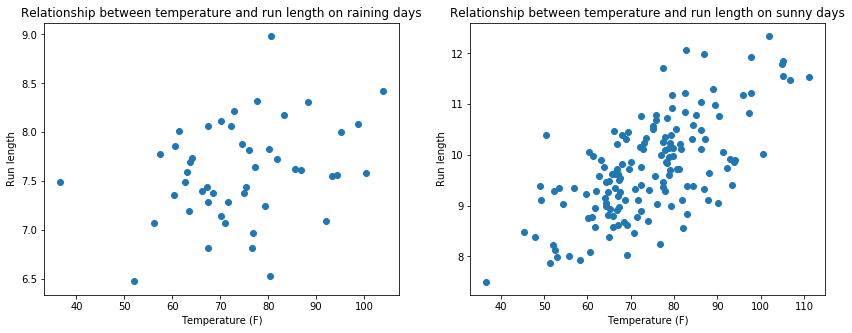

In [67]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
rain_df = df.loc[df["rain"]=="Yes"]
plt.scatter(rain_df["temperature"], rain_df["length"])
plt.xlabel("Temperature (F)")
plt.ylabel("Run length")
plt.title("Relationship between temperature and run length on raining days")
plt.subplot(1, 2, 2)
no_rain_df = df.loc[df["rain"]=="No"]
plt.scatter(no_rain_df["temperature"], no_rain_df["length"])
plt.xlabel("Temperature (F)")
plt.ylabel("Run length")
plt.title("Relationship between temperature and run length on sunny days")
plt.show()

#### Part D

Find the probability distributions for your run length on a day that is 80 degrees Fahrenheit and **not** raining, as well as run length on an 80-degree day when it **is** raining.  Plot these two distributions on the same set of axes, with run length (miles) on the x-axis and probability density on the y-axis. Include a legend and appropriate axis labels.

#### Part E

Use approximate Bayesian computation (i.e., sampling) to estimate the probability of going on a run **at least** 8 miles in length. 

[Back to top](#top)

<a/ id='p3'></a>

---
## [25 pts] Problem 3:  Markov chain Monte Carlo

Consider the problem of estimating the slope and intercept parameters for a linear model. Suppose this linear model represents the amount of ice cream you will consume ($y$, in pints) after going on a bike ride of length $x$ (in miles).

$$y = \alpha x + \beta$$

#### Part A

Fix the $x$ distance values at which we will estimate our ice cream intake covering the 0 to 9.9 range (inclusive), at intervals of 0.1 miles. Let $\alpha^* = 0.5$ and $\beta^* = 8$ represent the true parameters for your linear model. Generate a synthetic data set of ice cream eaten for each bike ride length $x$, assuming that measured ice cream consumption is normally distributed, centered at the true model and with standard deviation $\sigma = 1$. Create a scatter plot of you true model and the "observed" data, with appropriate axis labels and a legend.

**Question:** How many data points are there?

#### Part B

In class, we used the posterior score itself to calculate acceptance probabilities at iteration $t$ for the Metropolis-Hastings algorithm:

$$p_{accept} = \dfrac{\pi(\theta_{new} \mid y_{meas})}{\pi(\theta_{t} \mid y_{meas})},$$

where $\theta_t = (\alpha_t, T_{eq,t})$ are the parameter estimates in our Markov chain at iteration $t$ and $y_{meas}$ is the data.  But it is much more numerically stable to use the natural logarithm of the posterior score in most applications. 

1. Define a log-posterior function to return the logarithm of the posterior score for a given set of parameter values, varying *both* $\alpha$ and $\beta$. Use uniform prior distributions, for $\alpha \in [0,5]$ and $\beta \in [0,15]$. You may assume that $\alpha$ and $\beta$ are independent, so their prior distribution factors as $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$.
2. Calculate the simple least squares regression estimates of $\alpha$ and $\beta$, and report their log-posterior score.

#### Part C

To use the log-posterior as our objective function, we need to modify the Metropolis-Hastings acceptance probability so we can calculate it in terms of posterior scores (the right hand side below):

$$\log{(p_{accept})} = \log{\left(\dfrac{\pi(\theta_{new} \mid y_{meas})}{\pi(\theta_{t} \mid y_{meas})}\right)} = \log{(\pi(\theta_{new} \mid y_{meas}))} - \log{(\pi(\theta_{t} \mid y_{meas}))}$$

If you exponentiate both sides, things should start to look familiar from simulated annealing:

$$\exp{\left[\log{(p_{accept})}\right]} = p_{accept} = \exp{\left[\log{(\pi(\theta_{new} \mid y_{meas}))} - \log{(\pi(\theta_{t} \mid y_{meas}))}\right]}$$

Implement this in the Metropolis-Hastings algorithm.  Use a multivariate normal distribution to propose new parameters $(\alpha, \beta)$ jointly.

#### Part D

Obtain samples from the posterior distribution of $\alpha$ and $\beta$ by running the Metropolis-Hastings algorithm for 5000 iterations.  Start with the least squares estimates from Part B as the initial values for each parameter. The step sizes for the parameters should be chosen such that the acceptance rate is somewhere between 23 and 44%. Remove the first half of each Markov chain for burn-in, and save the rest for analysis.

1. Create a two-panel figure of the history plots of your Markov chains for each of $\alpha$ and $\beta$. Calculate and report the acceptance rate.
1. Create a two-panel figure of the histograms for your posterior samples for analysis for $\alpha$ and $\beta$. Label your axes appropriately.
1. Below your histogram, report on the 5-95% credible intervals (percentiles) for each parameter, as well as their posterior medians.

#### Part E

Now repeat this experiment, but only include a subsample of 50 data points out of the original set. Generate the same set of plots and diagnostic numbers as Part D. You may need to adjust the step sizes in order to obtain similar acceptance rates.

Compare the 5-95% credible intervals found in Part D and E, and comment on any differences you find.

[Back to top](#top)

<a/ id='p4'></a>

<br>

---
## [25 pts] Problem 4:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a [drone](https://twitter.com/Reuters/status/981121633023705088/video/1) to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if I say the drone is at $(x,y,z)$ I mean that it is in the box centered at $(x,y,z)$. And there are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. So, for example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins each training episode in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, which is just a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, which is a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the heck that landing pad is, and how to get there from any initial state.

#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and comment on the results:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values (see Section 21.3.2 in the textbook).  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. I refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever variety you would like.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your codes.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

<a/ id='bottom'></a>

[Back to top](#top)